# Import lib

In [1]:
#from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import *
%matplotlib inline

In [5]:
pip install cassandra-driver

In [2]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample

In [ ]:
data = pd.read_csv("card_transaction_v1.csv");

In [ ]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [ ]:
data.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')

In [ ]:
len(data)

24386900

In [ ]:
data.isna().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

In [ ]:
data.isna().mean()

User              0.000000
Card              0.000000
Year              0.000000
Month             0.000000
Day               0.000000
Time              0.000000
Amount            0.000000
Use Chip          0.000000
Merchant Name     0.000000
Merchant City     0.000000
Merchant State    0.111569
Zip               0.118020
MCC               0.000000
Errors?           0.984072
Is Fraud?         0.000000
dtype: float64

### Convert amount to numeric 

In [ ]:
data['Amount'] = data['Amount'].str.replace('$', '')
data['Amount'] = data['Amount'].astype(float)

<ipython-input-28-8e81dcaa021b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['Amount'] = data['Amount'].str.replace('$', '')


### Convert time (hr : minute) formate to only hour 

In [ ]:
data['hour'] = data['Time'].str.split(':').str[0]

In [ ]:
data['hour'] = data['hour'].astype(int)

In [ ]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,6
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,6
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,6
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,17
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,6


In [ ]:
data_state_na = data[data['Merchant State'].isna()]

In [ ]:
len(data_state_na)

2720821

In [ ]:
data_state_na.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour
11,0,0,2002,9,5,20:41,53.91,Online Transaction,-9092677072201095172,ONLINE,NaN,NaN,4900,NaN,No,20
24,0,0,2002,9,9,20:02,144.90,Online Transaction,-8338381919281017248,ONLINE,NaN,NaN,4899,NaN,No,20
85,0,0,2002,9,30,06:21,127.32,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No,6
99,0,0,2002,10,6,06:14,139.39,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No,6
106,0,0,2002,10,9,08:16,53.09,Online Transaction,-4956618006720593695,ONLINE,NaN,NaN,5193,NaN,No,8


In [ ]:
len(data_state_na[data_state_na['Is Fraud?'] == 'Yes'])

18349

In [ ]:
len(data_state_na[data_state_na['Merchant City'] == ' ONLINE'])

2720821

In [ ]:
len(data_state_na)

2720821

In [ ]:
data_state_na['Merchant City'].unique()

array([' ONLINE'], dtype=object)

In [ ]:
len(data_state_na[data_state_na['Merchant City'] == 'ONLINE'])

0

In [ ]:
len(data[data['Zip'].isna() & data['Merchant State'].notna()])

157314

In [ ]:
data_zip_na_state_notna = data[data['Zip'].isna() & data['Merchant State'].notna()]

In [ ]:
data_zip_na_state_notna.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour
407,0,0,2003,2,24,13:02,7.52,Swipe Transaction,-727612092139916043,Zurich,Switzerland,NaN,5411,NaN,No,13
408,0,0,2003,2,25,06:46,36.97,Swipe Transaction,-4816289482172287511,Zurich,Switzerland,NaN,5411,NaN,No,6
906,0,0,2004,7,22,06:32,38.26,Swipe Transaction,3510944833163794547,Tallinn,Estonia,NaN,5912,NaN,No,6
907,0,0,2004,7,23,20:05,75.38,Swipe Transaction,8793545055147237096,Tallinn,Estonia,NaN,5812,NaN,No,20
908,0,0,2004,7,25,13:08,16.20,Swipe Transaction,2027553650310142703,Tallinn,Estonia,NaN,5541,NaN,No,13


getting nan for the merchant state whenever the transaction made online and no data found for their state and zip code is also nan at that time. so replacing merchant state with online is the good choice. 

Zip column contains 11% of missing values, and that can be imputed if we find zip value for same merchant state and city for which we already have zip values. 

In [ ]:
data_zip_notna = data[data['Zip'].notna() & data['Merchant State'].notna()]

In [ ]:
data_zip_notna.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,6
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,6
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,6
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,17
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,6


### Impute Zip value

In [ ]:
data_zip_na_state_notna['Merchant State']. unique()

array(['Switzerland', 'Estonia', 'Japan', 'Mexico', 'Dominican Republic',
       'China', 'Portugal', 'Italy', 'Philippines', 'Jamaica', 'Canada',
       'France', 'Norway', 'New Zealand', 'Netherlands', 'Sierra Leone',
       'Haiti', 'South Korea', 'Spain', 'Algeria', 'Egypt', 'Indonesia',
       'United Kingdom', 'Colombia', 'South Africa', 'The Bahamas',
       'Singapore', 'Pakistan', 'Malaysia', 'Mongolia', 'Israel',
       'Hong Kong', 'Guatemala', 'Peru', 'Thailand', 'Sweden', 'Taiwan',
       'Germany', 'Czech Republic', 'India', 'Poland', 'Costa Rica',
       'Denmark', 'Bangladesh', 'Macedonia', 'Nigeria', 'Tuvalu',
       'Ireland', 'Vatican City', 'Lithuania', 'Papua New Guinea',
       'Belgium', 'Benin', 'Croatia', 'Saudi Arabia', 'Latvia', 'Austria',
       'Slovenia', 'Turkey', 'Russia', 'Greece', 'Slovakia', 'Brazil',
       'Hungary', 'Argentina', 'Serbia', 'Ghana', 'Oman',
       'United Arab Emirates', 'Finland', 'Barbados', 'Australia',
       'Vietnam', 'Micrones

In [ ]:
state_list = data_zip_notna['Merchant State'].unique()

In [ ]:
state_list

array(['CA', 'NE', 'IL', 'MO', 'IA', 'TX', 'NJ', 'NV', 'NY', 'AZ', 'UT',
       'FL', 'MI', 'WA', 'OH', 'NM', 'SC', 'AK', 'PA', 'VA', 'HI', 'CT',
       'MA', 'MN', 'CO', 'GA', 'AR', 'OR', 'WI', 'NC', 'WV', 'ME', 'NH',
       'VT', 'MD', 'AL', 'KY', 'TN', 'MS', 'KS', 'ND', 'DC', 'MT', 'OK',
       'WY', 'ID', 'RI', 'IN', 'LA', 'DE', 'SD', 'AA'], dtype=object)

for which we don't find zip code even though we have merchant state : the reason is merchant state doesn't contain "State" it contains "Country". so create new column Merchant Country and copy Merchant state value in Merchant country for which zip code is not avialable and merchant state is available. and impute "USA" as a country for which Zip code is avilable and then drop zip code column. 

In [ ]:
data['Zip'] = pd.to_numeric(data['Zip'], errors='coerce')

In [ ]:
data['Zip'] = data['Zip'].replace(np.nan, 0)

In [ ]:
data['Zip'] = data['Zip'].astype(int)

In [ ]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750,5300,NaN,No,6
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,6
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,6
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754,5651,NaN,No,17
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750,5912,NaN,No,6


In [ ]:
data['Merchant State'] = data['Merchant State'].str.strip()

In [ ]:
data['Merchant City'] = data['Merchant City'].str.strip()

In [ ]:
string = ""
if string == "":
    print("Empty")

Empty


In [ ]:
def imputCountry(row):  
    try : 
        if row['Zip'] == 0 and row['Merchant State'] != "":
            return row['Merchant State']
        elif row['Zip'] != 0 and row['Merchant State'] != "":
            return 'USA'
        if isNaN(row['Merchant State']):
            row['Merchant State'] = 'ONLINE'
        return 'ONLINE'
    except Exception as e:
        print("Error message : ------------ ", e)
        print(row['Zip'] , " ", row['Merchant State'])
        

In [ ]:
data['Merchant Country'] = data.apply(lambda row: imputCountry(row), axis=1)

In [ ]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour,Merchant Country
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750,5300,NaN,No,6,USA
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,6,USA
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,6,USA
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754,5651,NaN,No,17,USA
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750,5912,NaN,No,6,USA


In [ ]:
data.isna().sum()

User                       0
Card                       0
Year                       0
Month                      0
Day                        0
Time                       0
Amount                     0
Use Chip                   0
Merchant Name              0
Merchant City              0
Merchant State       2720821
Zip                        0
MCC                        0
Errors?             23998469
Is Fraud?                  0
hour                       0
Merchant Country     2720821
dtype: int64

In [ ]:
data[data['Merchant State'].isna()]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour,Merchant Country
11,0,0,2002,9,5,20:41,53.91,Online Transaction,-9092677072201095172,ONLINE,NaN,0,4900,NaN,No,20,NaN
24,0,0,2002,9,9,20:02,144.90,Online Transaction,-8338381919281017248,ONLINE,NaN,0,4899,NaN,No,20,NaN
85,0,0,2002,9,30,06:21,127.32,Online Transaction,-7421093378627544099,ONLINE,NaN,0,5311,NaN,No,6,NaN
99,0,0,2002,10,6,06:14,139.39,Online Transaction,-7421093378627544099,ONLINE,NaN,0,5311,NaN,No,6,NaN
106,0,0,2002,10,9,08:16,53.09,Online Transaction,-4956618006720593695,ONLINE,NaN,0,5193,NaN,No,8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386877,1999,1,2020,2,24,20:04,55.79,Online Transaction,-6160036380778658394,ONLINE,NaN,0,4121,NaN,No,20,NaN
24386879,1999,1,2020,2,25,07:06,43.08,Online Transaction,-6160036380778658394,ONLINE,NaN,0,4121,NaN,No,7,NaN
24386880,1999,1,2020,2,25,07:34,43.76,Online Transaction,-6160036380778658394,ONLINE,NaN,0,4121,NaN,No,7,NaN
24386884,1999,1,2020,2,26,07:43,45.18,Online Transaction,-6160036380778658394,ONLINE,NaN,0,4121,NaN,No,7,NaN


### What kind of errors are there in the Error column 

In [ ]:
data['Errors?'].unique()

array([nan, 'Technical Glitch,', 'Insufficient Balance,', 'Bad PIN,',
       'Bad PIN,Insufficient Balance,', 'Bad Expiration,',
       'Bad PIN,Technical Glitch,', 'Bad Card Number,', 'Bad CVV,',
       'Bad Zipcode,', 'Insufficient Balance,Technical Glitch,',
       'Bad Card Number,Insufficient Balance,',
       'Bad Card Number,Bad CVV,', 'Bad CVV,Insufficient Balance,',
       'Bad Card Number,Bad Expiration,', 'Bad Expiration,Bad CVV,',
       'Bad Expiration,Insufficient Balance,',
       'Bad Expiration,Technical Glitch,',
       'Bad Card Number,Bad Expiration,Technical Glitch,',
       'Bad CVV,Technical Glitch,', 'Bad Card Number,Technical Glitch,',
       'Bad Zipcode,Insufficient Balance,',
       'Bad Zipcode,Technical Glitch,',
       'Bad Card Number,Bad Expiration,Insufficient Balance,'],
      dtype=object)

In [ ]:
data_error_na = data[data['Errors?'].isna()]

In [ ]:
len(data_error_na[data_error_na['Is Fraud?'] == "Yes"])

28471

Error column contains many missing values and most of them are not directly relavant to the transaction being fraud or not as many error value being null is related to the transaction being legitimate. 

In [ ]:
data[data['Is Fraud?'] == "Yes"].groupby('Errors?').count()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,hour,Merchant Country
Errors?,,,,,,,,,,,,,,,,
"Bad CVV,",280,280,280,280,280,280,280,280,280,280,0,280,280,280,280,0
"Bad CVV,Insufficient Balance,",4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,0
"Bad CVV,Technical Glitch,",1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0
"Bad Card Number,",105,105,105,105,105,105,105,105,105,105,0,105,105,105,105,0
"Bad Card Number,Insufficient Balance,",2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,0
"Bad Expiration,",120,120,120,120,120,120,120,120,120,120,0,120,120,120,120,0
"Bad Expiration,Bad CVV,",2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,0
"Bad Expiration,Insufficient Balance,",1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0
"Bad Expiration,Technical Glitch,",2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,0


### Impute missing value of merchant state and merchant country 

In [ ]:
data['Merchant State'] = data['Merchant State'].fillna('ONLINE')

In [ ]:
data['Merchant Country'] = data['Merchant Country'].fillna('ONLINE')

In [ ]:
data[data['Is Fraud?'] == "Yes"]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,hour,Merchant Country
4099,0,0,2015,11,15,12:55,287.13,Online Transaction,-8194607650924472520,ONLINE,ONLINE,0,3001,NaN,Yes,12,ONLINE
4100,0,0,2015,11,15,13:19,2.41,Online Transaction,-7759074308363763111,ONLINE,ONLINE,0,5651,NaN,Yes,13,ONLINE
4101,0,0,2015,11,16,09:41,50.81,Online Transaction,-551332107213382088,ONLINE,ONLINE,0,4411,NaN,Yes,9,ONLINE
4102,0,0,2015,11,16,09:46,248.36,Online Transaction,4872340518840476610,ONLINE,ONLINE,0,5732,NaN,Yes,9,ONLINE
4103,0,0,2015,11,16,11:20,473.00,Online Transaction,-8566951830324093739,ONLINE,ONLINE,0,3640,NaN,Yes,11,ONLINE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24375668,1997,2,2016,9,4,10:45,1.25,Online Transaction,6455213054093379528,ONLINE,ONLINE,0,5815,NaN,Yes,10,ONLINE
24375670,1997,2,2016,9,4,12:30,116.66,Online Transaction,822647939787511611,ONLINE,ONLINE,0,5311,NaN,Yes,12,ONLINE
24375671,1997,2,2016,9,4,12:40,359.99,Online Transaction,8080934608468946743,ONLINE,ONLINE,0,5310,NaN,Yes,12,ONLINE
24375672,1997,2,2016,9,4,13:45,351.51,Online Transaction,-4282466774399734331,ONLINE,ONLINE,0,4829,NaN,Yes,13,ONLINE


Drop Error and zip column 
user, Card and Merchant Name will not be useful in training ML models. 

In [ ]:
data = data.drop(['Errors?', 'Zip', 'User', 'Card', 'Merchant Name', 'Time'], axis=1)

In [ ]:
data.head()

### Convert categorical data to numeric data 

In [ ]:
data.columns = ['Year', 'Month',
             'Day',
             'Amount',
             'Use_Chip',
             'Merchant_City',
             'Merchant_State',
             'MCC',
             'IsFraud',
             'Hour',
             'Merchant_Country']

In [ ]:
data.head()

,Year,Month,Day,Amount,Use_Chip,Merchant_City,Merchant_State,MCC,IsFraud,Hour,Merchant_Country
0,2002,9,1,134.09,Swipe Transaction,La Verne,CA,5300,No,6,USA
1,2002,9,1,38.48,Swipe Transaction,Monterey Park,CA,5411,No,6,USA
2,2002,9,2,120.34,Swipe Transaction,Monterey Park,CA,5411,No,6,USA
3,2002,9,2,128.95,Swipe Transaction,Monterey Park,CA,5651,No,17,USA
4,2002,9,3,104.71,Swipe Transaction,La Verne,CA,5912,No,6,USA


In [ ]:
df = data.copy()

In [ ]:
LE = LabelEncoder()

df['Use_Chip'] = LE.fit_transform(df['Use_Chip'])
df['Merchant_City'] = LE.fit_transform(df['Merchant_City'])
df['Merchant_State'] = LE.fit_transform(df['Merchant_State'])
df['Merchant_Country'] = LE.fit_transform(df['Merchant_Country'])

In [ ]:
df['IsFraud'] = LE.fit_transform(df['IsFraud'])

In [ ]:
#df.head()

In [ ]:
df.to_csv('all_data_transaction_refined.csv',index=False)

### Split the data in to train, validation and test data and save in the directory 

In [3]:
df = pd.read_csv(r'all_data_transaction_refined.csv')

In [4]:
X = df.drop(['IsFraud'],axis=1)
y = df.IsFraud
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [5]:
y_train.value_counts()

0    18267942
1       22233
Name: IsFraud, dtype: int64

In [6]:
y.value_counts()

0    24357143
1       29757
Name: IsFraud, dtype: int64

### Balance the test data set by downsampling the test data

In [7]:
from imblearn.datasets import make_imbalance

In [8]:
y_test.value_counts()

0    6089201
1       7524
Name: IsFraud, dtype: int64

In [9]:
X_test_1, y_test_1 = make_imbalance(X_test, y_test, sampling_strategy={0: 7429, 1: 7429},random_state=14)

In [10]:
y_test_1.value_counts()

0    7429
1    7429
Name: IsFraud, dtype: int64

In [14]:
X_train_1, y_train_1 = make_imbalance(X_train, y_train, sampling_strategy={0: 10000, 1: 10000},random_state=14)

### Logistic Regression with hyper parameters

/Users/shilpi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MSE :  0.14860681114551083
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      7429
           1       0.87      0.82      0.85      7429

    accuracy                           0.85     14858
   macro avg       0.85      0.85      0.85     14858
weighted avg       0.85      0.85      0.85     14858

Accuracy:  0.8513931888544891


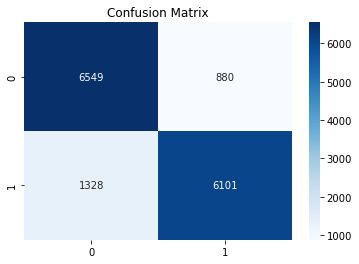

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_2, y_train_2)
y_pred_lr = lr_model.predict(X_test_1)
print("MSE : ", mean_squared_error(y_test_1, y_pred_lr))
print(classification_report(y_test_1, y_pred_lr))
print("Accuracy: ", accuracy_score(y_test_1, y_pred_lr))
cm = confusion_matrix(y_test_1, y_pred_lr)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

[14:40:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:41:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MSE :  0.049737515143357114
              precision    recall  f1-score   support

           0       0.95  

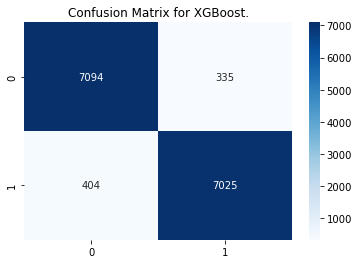

/Users/shilpi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


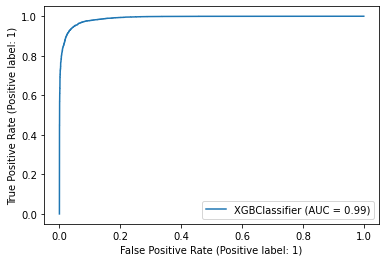

In [21]:
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as metrics
import xgboost as xgb
xgb_itr_model = xgb.XGBClassifier(max_depth=16, eta=0.4, silent=1, objective="binary:logistic", n_estimators=250, learning_rate=0.5, gamma=3)

xgb_itr_model.fit(X_train_1, y_train_1)

#x_train_itr_xgb, x_test_itr_xgb, y_train_itr_xgb, y_test_itr_xgb = get_test_train(cardio_train_validation_df_iterative_data, cardio_train_validation_df_iterative_target)
xgb_itr_model.fit(X_train_1, y_train_1)
#print(cross_val_score(xgb_itr_model, x_train_itr_xgb, y_train_itr_xgb, cv=7))
y_pred_XB = xgb_itr_model.predict(X_test_1)

print("MSE : ", mean_squared_error(y_test_1, y_pred_XB))
print(classification_report(y_test_1, y_pred_XB))
print("Accuracy: ", accuracy_score(y_test_1, y_pred_XB))
cm = confusion_matrix(y_test_1, y_pred_XB)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix for XGBoost.')
plt.show()

metrics.plot_roc_curve(xgb_itr_model, X_test_1, y_test_1)
plt.show()

## Random Forest

MSE :  0.058487010364786644
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7429
           1       0.96      0.92      0.94      7429

    accuracy                           0.94     14858
   macro avg       0.94      0.94      0.94     14858
weighted avg       0.94      0.94      0.94     14858

Accuracy:  0.9415129896352133


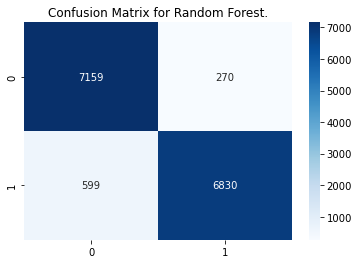

In [23]:
from sklearn.ensemble import RandomForestClassifier
import time
start_time=time.time()

model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

model_random_forest = RandomForestClassifier(n_estimators=100, max_features = 'sqrt')

model_random_forest.fit(X_train_1, y_train_1)
y_pred_randomForest = model_random_forest.predict(X_test_1)

print("MSE : ", mean_squared_error(y_test_1, y_pred_randomForest))
print(classification_report(y_test_1, y_pred_randomForest))
print("Accuracy: ", accuracy_score(y_test_1, y_pred_randomForest))
cm = confusion_matrix(y_test_1, y_pred_randomForest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix for Random Forest.')
plt.show()